# Reward shaping 1

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import gym
from collections import namedtuple
import numpy as np
import matplotlib
from itertools import count
import random
import math
from copy import deepcopy
import matplotlib.pyplot as plt
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display


In [2]:
replay = namedtuple('replay',('state','action','reward','next_state'))

class Replay_buffer():
    
    def __init__(self , buffer_size):
        self.buffer_size = buffer_size
        self.buffer = np.zeros(  [buffer_size] , dtype = replay)
        self.index = 0
        self.cur_size = 0
        
    def push(self,experience):
        self.buffer[self.index] = experience
        self.index = (self.index+1)%self.buffer_size
        if self.cur_size < self.buffer_size:
            self.cur_size += 1
    def sample(self,batch_size):
        sample_index = np.random.choice(np.arange(self.cur_size),size=batch_size,replace=False)
        return self.buffer[sample_index]

    
class DQN(nn.Module): #Shallow QN
    
    def __init__(self):
        super(DQN,self).__init__()
        self.L1 = nn.Linear(2,128)
        self.L2 = nn.Linear(128,64)
        self.out = nn.Linear(64,3)
    
    def forward(self,x):
        x = F.tanh(self.L1(x))
        x = F.tanh(self.L2(x))
        x = self.out(x)
        return x

In [3]:
num_epsoide = 700

network = DQN()
target_network = DQN()
target_network.load_state_dict(network.state_dict())
loss_fn = torch.nn.MSELoss(size_average=True)
buffer = Replay_buffer(15000)
EPS_START = 0.999
EPS_END = 0.1
EPS_DECAY = 50000
steps_done = 0
batch_size = 64
use_cuda = torch.cuda.is_available() 
#use_cuda = False
optimizer = torch.optim.RMSprop(network.parameters())

if use_cuda:
    network = network.cuda()
    target_network = target_network.cuda()
    
env = gym.make('MountainCar-v0').unwrapped
reward_history = []
max_position = -2.0
try:
    for e in range(num_epsoide):
        state = env.reset()
        state = torch.tensor(state).float()
        DONE = False
        acc_reward = 0
        for time_step in count():
            if DONE:
                break
            if e % 100 == 0:
                env.render()
            eps_threshold = EPS_END + \
            (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)

            if use_cuda:
                state = state.cuda()
            
            if random.random() >= eps_threshold:
                action = torch.argmax(network(state))
            else:
                action = torch.tensor(env.action_space.sample(),dtype=torch.long)
                
                
            next_state , reward , done , _ = env.step(action.item())
            steps_done += 1
            
            #reward += abs(next_state[0]+0.8) + next_state[1]*10  
            if state[0] <= next_state[0]:
                reward += abs(next_state[0]+0.8) + next_state[1]*10  
                #hint: abs(next_state[0]+c) + next_state[1]*k
                #reward += abs(next_state[0]+0.6) + next_state[1]*8
            else:
                reward -= 0.01
            acc_reward += reward
            
            next_state = torch.tensor(next_state).float()
            
            if done == True or time_step >= 200:
                if next_state[0] >= 0.5:
                    reward = 100.0 
                    print('------------done-----------')
                DONE = True
                next_state = None
                
            
            experience = replay(state , torch.tensor([action]).long(), \
                                torch.tensor([reward]) , next_state)
            buffer.push(experience)
            
            state = next_state
        
            
        
            if buffer.cur_size >= batch_size:

                batch = buffer.sample(batch_size=batch_size)
                batch = replay(*zip(*batch))

                non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                              batch.next_state)), dtype=torch.uint8)

                non_final_next_state = torch.cat([s for\
                                                  s in batch.next_state if s is not None]).view(-1,2)
                
                state_batch = torch.cat(batch.state).view(-1,2)
                reward_batch = torch.cat(batch.reward)
                action_batch = torch.cat(batch.action).view(-1,1)
                if use_cuda:
                    state_batch = state_batch.cuda()
                    reward_batch = reward_batch.cuda()
                    action_batch = action_batch.cuda()
                    non_final_next_state = non_final_next_state.cuda()
                    non_final_mask = non_final_mask.cuda()
                next_state_values = torch.zeros(batch_size)
                if use_cuda:
                    next_state_values = next_state_values.cuda()
                next_state_values[non_final_mask] = target_network(non_final_next_state).max(1)[0]
                expected_state_values = next_state_values + reward_batch.view(-1)
                expected_state_values = expected_state_values
                state_action_value = network(state_batch).gather(1,action_batch).view(-1)
                expected_state_values = expected_state_values.detach()
                
                    
                
                loss = loss_fn(state_action_value,expected_state_values)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                if e %30 == 0:
                    target_network.load_state_dict(network.state_dict())
        reward_history.append(acc_reward)
        print(e)
        print(eps_threshold)
finally:
    env.close()

/home/fung/.local/lib/python2.7/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
/home/fung/.local/lib/python2.7/site-packages/torch/nn/functional.py:1374: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


0
0.99541118242
1
0.991818854883
2
0.988240939515
3
0.984677378495
4
0.981128114234
5
0.977593089375
6
0.974072246791
7
0.970565529583
8
0.967072881081
9
0.963594244843
10
0.960129564652
11
0.956678784517
12
0.953241848673
13
0.949818701577
14
0.946409287909
15
0.943013552573
16
0.939631440691
17
0.936262897608
18
0.932907868885
19
0.929566300305
20
0.926238137867
21
0.922923327785
22
0.919621816491
23
0.916333550631
24
0.913058477066
25
0.909796542869
26
0.906547695325
27
0.903311881933
28
0.900089050399
29
0.896879148642
30
0.893682124787
31
0.890497927171
32
0.887326504335
33
0.884167805027
34
0.881021778201
35
0.877888373017
36
0.874767538837
37
0.871659225227
38
0.868563381956
39
0.865479958993
40
0.862408906509
41
0.859350174875
42
0.856303714659
43
0.853269476631
44
0.850247411755
45
0.847237471194
46
0.844239606306
47
0.841253768643
48
0.838279909954
49
0.83531798218
50
0.832367937454
51
0.829429728103
52
0.826503306644
53
0.823588625785
54
0.820685638424
55
0.817794297646
56
0

440
0.252701194462
441
0.252088567865
442
0.251478399083
443
0.250870678256
444
0.250265395562
445
0.249662541221
446
0.24906210549
447
0.248464078665
448
0.247868451083
449
0.247275213116
450
0.24668435518
451
0.246095867724
452
0.24550974124
453
0.244925966254
454
0.244344533333
455
0.24376543308
456
0.243188656137
457
0.242614193184
458
0.242042034936
459
0.241472172147
460
0.240904595608
461
0.240339296147
462
0.239776264628
463
0.239215491953
464
0.238656969058
465
0.238100686919
466
0.237546636545
467
0.236994808983
468
0.236445195314
469
0.235897786657
470
0.235352574166
471
0.23480954903
472
0.234268702473
473
0.233730025755
474
0.23319351017
475
0.232659147049
476
0.232126927755
477
0.231596843688
478
0.231068886282
479
0.230543047004
480
0.230019317357
481
0.229497688877
482
0.228978153134
483
0.228460701733
484
0.227945326311
485
0.227432018539
486
0.226920770122
487
0.226411572798
488
0.225904418339
489
0.225399298549
490
0.224896205263
491
0.224395130354
492
0.223896065722

([<matplotlib.lines.Line2D at 0x7f089d415b90>], 700)

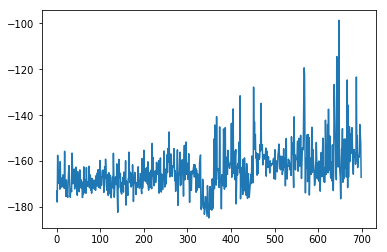

In [4]:
import matplotlib.pyplot as plt
plt.plot(reward_history),len(reward_history)

In [5]:
from PIL import Image
try:
    env = gym.make('MountainCar-v0').unwrapped
    frames = []
    DONE = False
    state = env.reset()
    state = torch.tensor(state).float()
    if use_cuda:
        state = torch.tensor(state).float()
    for t in count():
        env.render(mode='rgb_array')
        frames.append(Image.fromarray(env.render(mode='rgb_array')))
        if use_cuda:
            state = state.cuda()
        action = torch.argmax(network(state))
        print(action)
        next_state , reward , done , _ = env.step(action.item())
        
        state = torch.tensor(next_state).float()
        if use_cuda:
            state = state.cuda()
        if t >= 200:
            print('done')
            break
finally:
    env.close()
    with open('mc.gif','wb') as f:
        im = Image.new('RGB', frames[0].size)
        im.save(f, save_all=True, append_images=frames)


tensor(2)
tensor(2)
tensor(2)
tensor(2)
tensor(2)
tensor(2)
tensor(2)
tensor(2)
tensor(2)
tensor(2)
tensor(2)
tensor(2)
tensor(2)
tensor(2)
tensor(2)
tensor(2)
tensor(2)
tensor(2)
tensor(2)
tensor(2)
tensor(2)
tensor(2)
tensor(2)
tensor(2)
tensor(2)
tensor(2)
tensor(1)
tensor(1)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(1)
tensor(2)
tensor(2)
tensor(2)
tensor(2)
tensor(2)
tensor(2)
tensor(2)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(0)
tensor(0)
tensor(2)
tensor(2)
tensor(2)
tensor(2)
tensor(1)
tensor(1)
tensor(1)
tensor(2)
tensor(0)
tensor(2)
tensor(2)
tensor(2)
tensor(2)
tensor(2)
tensor(2)
tensor(2)


# Reward shaping 2

In [10]:
replay = namedtuple('replay',('state','action','reward','next_state'))

class Replay_buffer():
    
    def __init__(self , buffer_size):
        self.buffer_size = buffer_size
        self.buffer = np.zeros(  [buffer_size] , dtype = replay)
        self.index = 0
        self.cur_size = 0
        
    def push(self,experience):
        self.buffer[self.index] = experience
        self.index = (self.index+1)%self.buffer_size
        if self.cur_size < self.buffer_size:
            self.cur_size += 1
    def sample(self,batch_size):
        sample_index = np.random.choice(np.arange(self.cur_size),size=batch_size,replace=False)
        return self.buffer[sample_index]

    
class DQN(nn.Module): #Shallow QN
    
    def __init__(self):
        super(DQN,self).__init__()
        self.L1 = nn.Linear(2,128)
        self.L2 = nn.Linear(128,64)
        self.out = nn.Linear(64,3)
    
    def forward(self,x):
        x = F.tanh(self.L1(x))
        x = F.tanh(self.L2(x))
        x = self.out(x)
        return x

In [11]:
num_epsoide = 700

network = DQN()
target_network = DQN()
target_network.load_state_dict(network.state_dict())
loss_fn = torch.nn.MSELoss(size_average=True)
buffer = Replay_buffer(15000)
EPS_START = 0.999
EPS_END = 0.1
EPS_DECAY = 50000
steps_done = 0
batch_size = 64
use_cuda = torch.cuda.is_available() 
#use_cuda = False
optimizer = torch.optim.RMSprop(network.parameters())

if use_cuda:
    network = network.cuda()
    target_network = target_network.cuda()
    
env = gym.make('MountainCar-v0').unwrapped
reward_history = []
max_position = -2.0
try:
    for e in range(num_epsoide):
        state = env.reset()
        state = torch.tensor(state).float()
        DONE = False
        acc_reward = 0
        for time_step in count():
            if DONE:
                break
            if e % 100 == 0:
                env.render()
            eps_threshold = EPS_END + \
            (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)

            if use_cuda:
                state = state.cuda()
            
            if random.random() >= eps_threshold:
                action = torch.argmax(network(state))
            else:
                action = torch.tensor(env.action_space.sample(),dtype=torch.long)
                
                
            next_state , reward , done , _ = env.step(action.item())
            steps_done += 1
            
            #reward += abs(next_state[0]+0.8) + next_state[1]*10  
            if state[1] < next_state[1]:
                reward += abs(next_state[0]+0.8) + next_state[1]*10  
                #hint: abs(next_state[0]+c) + next_state[1]*k
                #reward += abs(next_state[0]+0.6) + next_state[1]*8
            else:
                reward -= 0.01
            acc_reward += reward
            
            next_state = torch.tensor(next_state).float()
            
            if done == True or time_step >= 200:
                if next_state[0] >= 0.5:
                    reward = 100.0 
                    print('------------done-----------')
                DONE = True
                next_state = None
                
            
            experience = replay(state , torch.tensor([action]).long(), \
                                torch.tensor([reward]) , next_state)
            buffer.push(experience)
            
            state = next_state
        
            
        
            if buffer.cur_size >= batch_size:

                batch = buffer.sample(batch_size=batch_size)
                batch = replay(*zip(*batch))

                non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                              batch.next_state)), dtype=torch.uint8)

                non_final_next_state = torch.cat([s for\
                                                  s in batch.next_state if s is not None]).view(-1,2)
                
                state_batch = torch.cat(batch.state).view(-1,2)
                reward_batch = torch.cat(batch.reward)
                action_batch = torch.cat(batch.action).view(-1,1)
                if use_cuda:
                    state_batch = state_batch.cuda()
                    reward_batch = reward_batch.cuda()
                    action_batch = action_batch.cuda()
                    non_final_next_state = non_final_next_state.cuda()
                    non_final_mask = non_final_mask.cuda()
                next_state_values = torch.zeros(batch_size)
                if use_cuda:
                    next_state_values = next_state_values.cuda()
                next_state_values[non_final_mask] = target_network(non_final_next_state).max(1)[0]
                expected_state_values = next_state_values + reward_batch.view(-1)
                expected_state_values = expected_state_values
                state_action_value = network(state_batch).gather(1,action_batch).view(-1)
                expected_state_values = expected_state_values.detach()
                
                    
                
                loss = loss_fn(state_action_value,expected_state_values)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                if e %30 == 0:
                    target_network.load_state_dict(network.state_dict())
        reward_history.append(acc_reward)
        print(e)
        print(eps_threshold)
finally:
    env.close()

0
0.99541118242
1
0.991818854883
2
0.988240939515
3
0.984677378495
4
0.981128114234
5
0.977593089375
6
0.974072246791
7
0.970565529583
8
0.967072881081
9
0.963594244843
10
0.960129564652
11
0.956678784517
12
0.953241848673
13
0.949818701577
14
0.946409287909
15
0.943013552573
16
0.939631440691
17
0.936262897608
18
0.932907868885
19
0.929566300305
20
0.926238137867
21
0.922923327785
22
0.919621816491
23
0.916333550631
24
0.913058477066
25
0.909796542869
26
0.906547695325
27
0.903311881933
28
0.900089050399
29
0.896879148642
30
0.893682124787
31
0.890497927171
32
0.887326504335
33
0.884167805027
34
0.881021778201
35
0.877888373017
36
0.874767538837
37
0.871659225227
38
0.868563381956
39
0.865479958993
40
0.862408906509
41
0.859350174875
42
0.856303714659
43
0.853269476631
44
0.850247411755
45
0.847237471194
46
0.844239606306
47
0.841253768643
48
0.838279909954
49
0.83531798218
50
0.832367937454
51
0.829429728103
52
0.826503306644
53
0.823588625785
54
0.820685638424
55
0.817794297646
56
0

440
0.252701194462
441
0.252088567865
442
0.251478399083
443
0.250870678256
444
0.250265395562
445
0.249662541221
446
0.24906210549
447
0.248464078665
448
0.247868451083
449
0.247275213116
450
0.24668435518
451
0.246095867724
452
0.24550974124
453
0.244925966254
454
0.244344533333
455
0.24376543308
456
0.243188656137
457
0.242614193184
458
0.242042034936
459
0.241472172147
460
0.240904595608
461
0.240339296147
462
0.239776264628
463
0.239215491953
464
0.238656969058
465
0.238100686919
466
0.237546636545
467
0.236994808983
468
0.236445195314
469
0.235897786657
470
0.235352574166
471
0.23480954903
472
0.234268702473
473
0.233730025755
474
0.23319351017
475
0.232659147049
476
0.232126927755
477
0.231596843688
478
0.231068886282
479
0.230543047004
480
0.230019317357
481
0.229497688877
482
0.228978153134
483
0.228460701733
484
0.227945326311
485
0.227432018539
486
0.226920770122
487
0.226411572798
488
0.225904418339
489
0.225399298549
490
0.224896205263
491
0.224395130354
492
0.223896065722

([<matplotlib.lines.Line2D at 0x7f08902b3910>], 700)

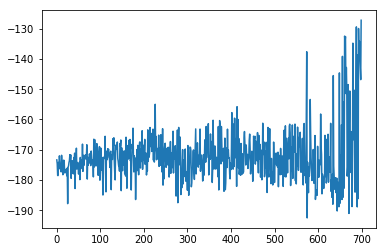

In [12]:
plt.plot(reward_history),len(reward_history)

In [13]:
from PIL import Image
try:
    env = gym.make('MountainCar-v0').unwrapped
    frames = []
    DONE = False
    state = env.reset()
    state = torch.tensor(state).float()
    if use_cuda:
        state = torch.tensor(state).float()
    for t in count():
        env.render(mode='rgb_array')
        frames.append(Image.fromarray(env.render(mode='rgb_array')))
        if use_cuda:
            state = state.cuda()
        action = torch.argmax(network(state))
        print(action)
        next_state , reward , done , _ = env.step(action.item())
        
        state = torch.tensor(next_state).float()
        if use_cuda:
            state = state.cuda()
        if t >= 200:
            print('done')
            break
finally:
    env.close()
    with open('mc2.gif','wb') as f:
        im = Image.new('RGB', frames[0].size)
        im.save(f, save_all=True, append_images=frames)

tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(1)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(2)
tensor(2)
tensor(2)
tensor(2)
tensor(2)
tensor(2)
tensor(0)
tensor(0)
tensor(2)
tensor(2)
tensor(2)
tensor(2)
tensor(2)
tensor(2)
tensor(2)
tensor(2)
tensor(2)
tensor(2)
tensor(2)
tensor(2)
tensor(2)
tensor(2)
tensor(2)
tensor(2)
tensor(2)
tensor(2)
tensor(2)
tensor(2)
tensor(2)
tensor(2)
tensor(2)
tensor(2)
tensor(2)
tensor(2)
tensor(2)
tensor(2)
tensor(2)
tensor(2)
tensor(2)
tensor(2)
tensor(2)
tensor(2)
tensor(2)
tensor(2)
tensor(2)
tensor(2)
tensor(2)
tensor(2)
tensor(2)
tensor(2)
tensor(2)
tensor(2)
tensor(2)
tensor(2)
tensor(2)
tensor(2)
tensor(2)
tensor(2)
tensor(2)
tensor(2)
tensor(2)
tensor(2)
tensor(2)
tensor(2)
tensor(2)
tensor(2)
tensor(2)
tensor(2)
